This tutorial will cover the basics up to predicting the 21-cm power spectrum and global signal. We will start by importing the necessary packages (Zeus, numpy, class)

In [1]:
import sys
sys.path.append("../")

import zeus21
from matplotlib import pyplot as plt
import numpy as np


#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

%load_ext autoreload
%autoreload 2

Now we set up the cosmology and astrophysics -- This will do the bulk of the work

We begin by running CLASS, where you can change the input parameters as shown below. Then we save the cosmo parameters, the correlation functions, and the halo mass function at all desired z and M.

After that we set up the astro parameters, calculate the SFRD and with it all the global signal and related quantities. In principle one can re-run the astrophysics part only if you're certain of the cosmology parameters. With the current implementation they take a comparable amount of time (classy takes ~5s and Zeus ~3s).

In [2]:
#set up your parameters here, as an example the CDM (reduced) density
omega_cdm = 0.12
CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omega_cdm)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [3]:
#define all cosmology (including derived) parameters, and save them to the CosmoParams structure
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(CosmoParams)
print('Correlation functions saved.')
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

#set up your astro parameters too, here the peak of f*(Mh) as an example
epsilon_star = 0.15
AstroParams = zeus21.Astro_Parameters(CosmoParams, epsstar=epsilon_star)


ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure = zeus21.get_T21_coefficients(CosmoParams, AstroParams, HMFintclass, zmin=ZMIN)
zlist = CoeffStructure.zintegral
print('SFRD and coefficients stored. Move ahead.')

Correlation functions saved.
HMF interpolator built. This ends the cosmology part -- moving to astrophysics.


NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

The CoeffStructure holds all the information needed to find the 21-cm signal during cosmic dawn. It has saved the 21-cm global signal, the Wouthuysen-Field coupling, and all temperatures. It also has the effective biases $\gamma_R$ for all $R$ (which will be used for the power spectrum below). This structure also has ancillary data like the evolution of the SFRD and Nion. If you want to learn what else the CoeffStructure holds, just do dir(CoeffStructure)

Let us start by plotting the global signal.

(10.0, 25.0)

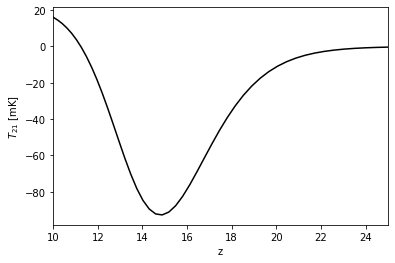

In [ ]:
plt.plot(zlist,CoeffStructure.T21avg, 'k')
plt.xlabel(r'z');
plt.ylabel(r'$T_{21}$ [mK]');
plt.xlim([10, 25])

It has the usual absorption trough around $z\sim15$ that we know and love (given so far we only have atomic-cooling haloes), and turns into emission at $z\sim11$. Since we're stopping at `ZMIN=10` we don't get to see the bulk of reionization, but it's stored in CoeffStructure.xHI_avg.

Let us plot the relevant temperatures too. Here is the CMB temperature $T_{\rm CMB}$; the gas kinetic temperature $T_k$, which has an adiabatic/cosmological and an X-ray component; and the spin temperature $T_S$, which has the WF coupling in it (and we store its inverse in the code).

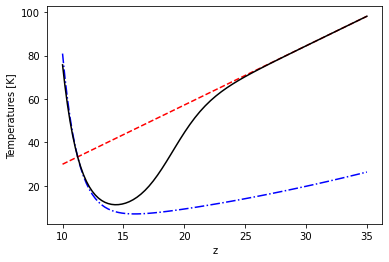

In [ ]:
plt.plot(zlist,CoeffStructure.T_CMB,'r--')
plt.plot(zlist,CoeffStructure.Tk_avg,'b-.')
plt.plot(zlist,1.0/CoeffStructure._invTs_avg,'k')
plt.xlabel(r'z');
plt.ylabel(r'Temperatures [K]');

This lines up with our expectation from the 21-cm global signal above. Absorption begins when $T_S$ departs from $T_{\rm CMB}$, at $z\sim 20$, as it begins to couple to $T_k$. It turns into emission at $z\sim 11$ when $T_S\sim T_k > T_{\rm CMB}$. Full WF coupling only occurs after there has been some X-ray heating, so we don't get a deep 21-cm trough for this model. This would be different with a lower X-ray luminosity $L_X$ as we will see below.

Let's move now to the 21-cm fluctuations.

In [ ]:
RSDMODE = 1 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21 = zeus21.Power_Spectra(CosmoParams, ClassyCosmo, CorrFClass, CoeffStructure, RSD_MODE = RSDMODE)
print('Computed the 21-cm power spectrum.')

Computed the 21-cm power spectrum.


(1, 200)

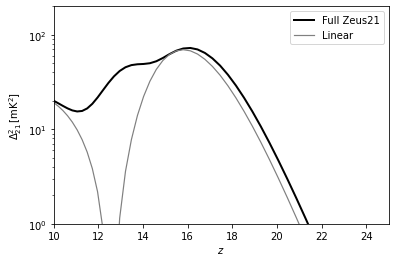

In [ ]:
#choose a k to plot
klist = PS21.klist_PS
kchoose=0.3;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))

plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik], color='k', linewidth=2.0)
plt.semilogy(zlist,PS21.Deltasq_T21_lin[:,_ik], color='gray', linewidth=1.2)

plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'Full Zeus21', r'Linear'])

plt.xlim([10, 25])
plt.ylim([1,200])

This shows the evolution of the fluctuations at a particular scale (i.e., wavenumber $k$). We have shown the full result from Zeus21, as well as the linear approximation (which is also stored). We can flip the script now and show the 21-cm power against wavenumber at a particular redshift.

(1, 200)

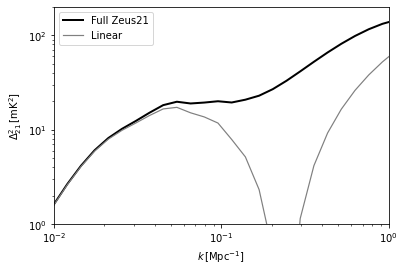

In [ ]:
#choose a z to plot
zchoose=13.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.loglog(klist,PS21.Deltasq_T21[_iz], color='k', linewidth=2.0)
plt.loglog(klist,PS21.Deltasq_T21_lin[_iz], color='gray', linewidth=1.2)

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'Full Zeus21', r'Linear'])

plt.xlim([1e-2,1])
plt.ylim([1,200])

This was for a specific set of astro+cosmo parameters. Let's do a different example with lower X-ray luminosity (which we expect will produce a deeper cosmic dawn absorption). This is controlled through the free parameter L40_xray (luminosity per unit SFR in units of 10^40 erg/s/SFR), with a fiducial value of 3.0. Let's lower it to 1.0 and see what happens.

In [ ]:
AstroParams_lowLX = zeus21.Astro_Parameters(CosmoParams, epsstar=epsilon_star, L40_xray=1.0)
CoeffStructure_lowLX = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams_lowLX, HMFintclass, zmin=ZMIN)
PS21_lowLX = zeus21.Power_Spectra(CosmoParams, ClassyCosmo, CorrFClass, CoeffStructure_lowLX, RSD_MODE = RSDMODE)

Note that we can re-run the astrophysics part only, so it should take ~few seconds in a laptop. Let's plot the global signal and fluctuations comparing with the fiducial case.

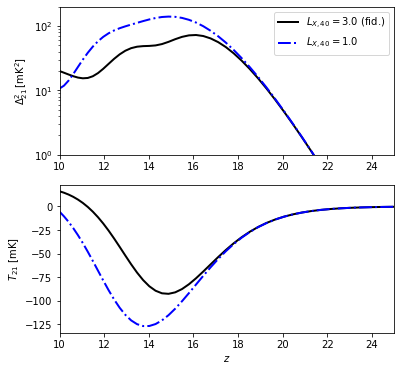

In [ ]:
f = plt.figure(figsize = (6,6))

ax = f.add_subplot(211)

plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik], 'k', linewidth=2.0)
plt.semilogy(zlist,PS21_lowLX.Deltasq_T21[:,_ik], 'b-.', linewidth=2.0)

plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'$L_{X,40} = 3.0$ (fid.)', r'$L_{X,40} = 1.0$'])
plt.xlim([10, 25]);
plt.ylim([1,200]);

ax = f.add_subplot(212)

plt.plot(zlist,CoeffStructure.T21avg, 'k', linewidth=2.0)
plt.plot(zlist,CoeffStructure_lowLX.T21avg, 'b-.', linewidth=2.0)

plt.xlabel(r'$z$');
plt.ylabel(r'$T_{21}$ [mK]');

plt.xlim([10, 25]);

Just as we expected! Lowering the X-ray luminosity (blue) makes for a deeper 21-cm global absorption, and larger 21-cm fluctuations too. By $z\sim 10$ there is still enough heating to raise the 21-cm signal near absorption. We can confirm this by plotting the spin temperature and comparing against the `standard' case

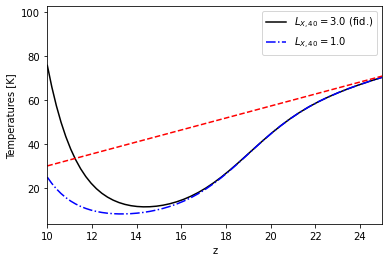

In [ ]:
plt.plot(zlist,1.0/CoeffStructure._invTs_avg,'k')
plt.plot(zlist,1.0/CoeffStructure_lowLX._invTs_avg,'b-.')
plt.plot(zlist,CoeffStructure.T_CMB,'r--')
plt.xlabel(r'z');
plt.ylabel(r'Temperatures [K]');
plt.legend([r'$L_{X,40} = 3.0$ (fid.)', r'$L_{X,40} = 1.0$'])
plt.xlim([10, 25]);

You're now ready to calculate any 21-cm power spectrum or global signal that you want!